After a recent meeting with Stephen discusing the strenghts and failings of different multiple comparisosns corrections
and mean significance policies, It became clear that perhaps taking the grand mean across multiple dprimes (with the
caveat of them being flipped to be positive), might not be the best options. Rather we could focus on individual cell
and context_pair/probe combinations, making some clasification based on their nature.

1. for a cell, for a probe, find all context_pairs and classify them as
    * silence - self
    * silence _ different [1,2,3]
    * self - different [1,2,3]
    * different [1,2] - different [2,3]
    * in total 10 different context_pairs classified into 4 groups
2. repeat for each probe
4. count only signficant dprimes, report the metric. and mean the metric across categories
5. report the mean and the proportion of significant dprimes.

In [105]:
import itertools as itt
from pathlib import Path
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from statannot import statannot
from cycler import cycler
from ipywidgets import interact, interact_manual, fixed

from src.data.region_map import region_map
from src.metrics.dprime import flip_dprimes
from src.metrics.consolidated_dprimes_v2 import single_cell_dprimes, probewise_LDA_dprimes, probewise_dPCA_dprimes, full_dPCA_dprimes
from src.metrics.consolidated_metrics import _append_means_to_array, metrics_to_DF, _append_means_to_shuff_array
from src.metrics.significance import _significance, _mask_with_significance

In [164]:
plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':False,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)


In [202]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path('../data/210302_consolidated_summary_DF/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'
ff_stim = DF.stim_type == 'permutations'
ff_mean = DF.mean_signif_type == 'shuffles'

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe, good_cols]


filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
# filtered['id_probe'] = filtered[['id', 'probe']].agg('_'.join, axis=1)
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

print('duplicated columns?: ', any(filtered.loc[:,[col for col in filtered.columns if col !='value']].duplicated()))

duplicated columns?:  False


In [203]:
# creates a new column relating probe with  context pairs
ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
prb = np.asarray(filtered.probe, dtype=int)

silence = ctx == 0
same = ctx == prb[:,None]
different = np.logical_and(~silence, ~same)

name_arr = np.full_like(ctx, np.nan, dtype=object)
name_arr[silence] = 'sile'
name_arr[same] = 'same'
name_arr[different] = 'diff'
comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

# swaps clasification names to not have repetitions i.e. diff_same == same_diff
comp_name_arr[np.where(comp_name_arr == 'self_sile')] = 'sile_self'
comp_name_arr[np.where(comp_name_arr == 'diff_sile')] = 'sile_diff'
comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'


filtered['trans_pair'] = comp_name_arr
classDF = filtered

In [204]:
# pivots to see an example cell clasification grid
print(classDF.columns)
ord_cols = ['analysis', 'mult_comp_corr', 'id', 'trans_pair', 'context_pair', 'probe', 'metric', 'value']
good_cols = [col for col in ord_cols if col not in ['value']]
print('duplicates?: ', np.any(classDF.loc[:, good_cols].duplicated()))
pivot_idx = [col for col in good_cols if col not in ['probe', 'metric','value']]
pivoted = classDF.pivot_table(index=pivot_idx, columns=['probe', 'metric'],  values='value', aggfunc='first')

# pivoted.swaplevel('context_pair',4, a)

Index(['analysis', 'mult_comp_corr', 'region', 'context_pair', 'probe',
       'metric', 'value', 'id', 'trans_pair'],
      dtype='object')
duplicates?:  False


In [205]:
pivoted.loc[('SC', 'time', 'AMT028b-04-1'),:].head()


probe                                             1                       \
metric                  significant_abs_mass_center significant_abs_mean   
trans_pair context_pair                                                    
diff_diff  1_2                                  NaN                  NaN   
           1_3                                  NaN                  NaN   
           1_4                                  NaN                  NaN   
           2_3                           322.002699             1.056268   
           2_4                             0.000000             0.000000   

probe                                                                 2  \
metric                  significant_abs_sum significant_abs_mass_center   
trans_pair context_pair                                                   
diff_diff  1_2                          NaN                         NaN   
           1_3                          NaN                   85.418464   
           1_4                          NaN                    0.000000   
           2_3                    70.417843                         NaN   
           2_4                     0.000000                         NaN   

probe                                                             \
metric                  significant_abs_mean significant_abs_sum   
trans_pair context_pair                                            
diff_diff  1_2                           NaN                 NaN   
           1_3                      1.207979           120.79787   
           1_4                      0.000000             0.00000   
           2_3                           NaN                 NaN   
           2_4                           NaN                 NaN   

probe                                             3                       \
metric                  significant_abs_mass_center significant_abs_mean   
trans_pair context_pair                                                    
diff_diff  1_2                            66.666667             0.830278   
           1_3                                  NaN                  NaN   
           1_4                             0.000000             0.000000   
           2_3                                  NaN                  NaN   
           2_4                           581.296223             1.083825   

probe                                                                 4  \
metric                  significant_abs_sum significant_abs_mass_center   
trans_pair context_pair                                                   
diff_diff  1_2                    55.351872                    0.000000   
           1_3                          NaN                  451.543023   
           1_4                     0.000000                         NaN   
           2_3                          NaN                    0.000000   
           2_4                    72.254988                         NaN   

probe                                                             
metric                  significant_abs_mean significant_abs_sum  
trans_pair context_pair                                           
diff_diff  1_2                      0.000000             0.00000  
           1_3                      0.879959            58.66392  
           1_4                           NaN                 NaN  
           2_3                      0.000000             0.00000  
           2_4                           NaN                 NaN

seems somewhat adecuate, I coult get rid of the filler nan by making some trans_pairs with numbers, but seems an unecesary
hasse. Lets rather figure out a way of counting and taking the mean across the different clasifications.


In [206]:
def nozero_nanmean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def percent_good(arr):
    total = np.sum(~np.isnan(arr))
    goods = np.sum(arr > 0)
    return goods/total * 100


print(classDF.columns)
# columns to aggregate are probe and trans_pair.
ord_cols = ['analysis', 'mult_comp_corr', 'id', 'trans_pair', 'probe', 'metric', 'value']
good_cols = [col for col in ord_cols if col not in ['value']]
print('duplicates?: ', np.any(classDF.loc[:, good_cols].duplicated()))
pivot_idx = [col for col in good_cols if col not in ['value', 'metric', 'probe']]
meanDF = classDF.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc=nozero_nanmean)
countDF = classDF.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc=percent_good)

Index(['analysis', 'mult_comp_corr', 'region', 'context_pair', 'probe',
       'metric', 'value', 'id', 'trans_pair'],
      dtype='object')
duplicates?:  True


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [211]:
# count DF shows consisten count between metrics, as it should. Take one of those colums and put it alongside the mean
# values
percent = countDF.drop(columns=['significant_abs_mass_center', 'significant_abs_mean']
                       ).rename(columns={'significant_abs_sum':'percentage'})
aggDF = pd.concat([meanDF, percent], axis=1)
aggDF = aggDF.reset_index()
aggDF.head(5)


metric,analysis,mult_comp_corr,id,trans_pair,significant_abs_mass_center,significant_abs_mean,significant_abs_sum,percentage
0,LDA,consecutive_2,AMT020a,diff_diff,41.955901,4.393250,338.707794,25.000000
1,LDA,consecutive_2,AMT020a,same_diff,52.407120,4.405992,347.666628,25.000000
2,LDA,consecutive_2,AMT020a,sile_diff,142.424091,3.929063,491.245043,75.000000
3,LDA,consecutive_2,AMT020a,sile_same,170.414396,4.527309,405.031202,100.000000
4,LDA,consecutive_2,AMT026a,diff_diff,30.440446,3.682897,296.625622,41.666667


# selects multiple comparisons correction

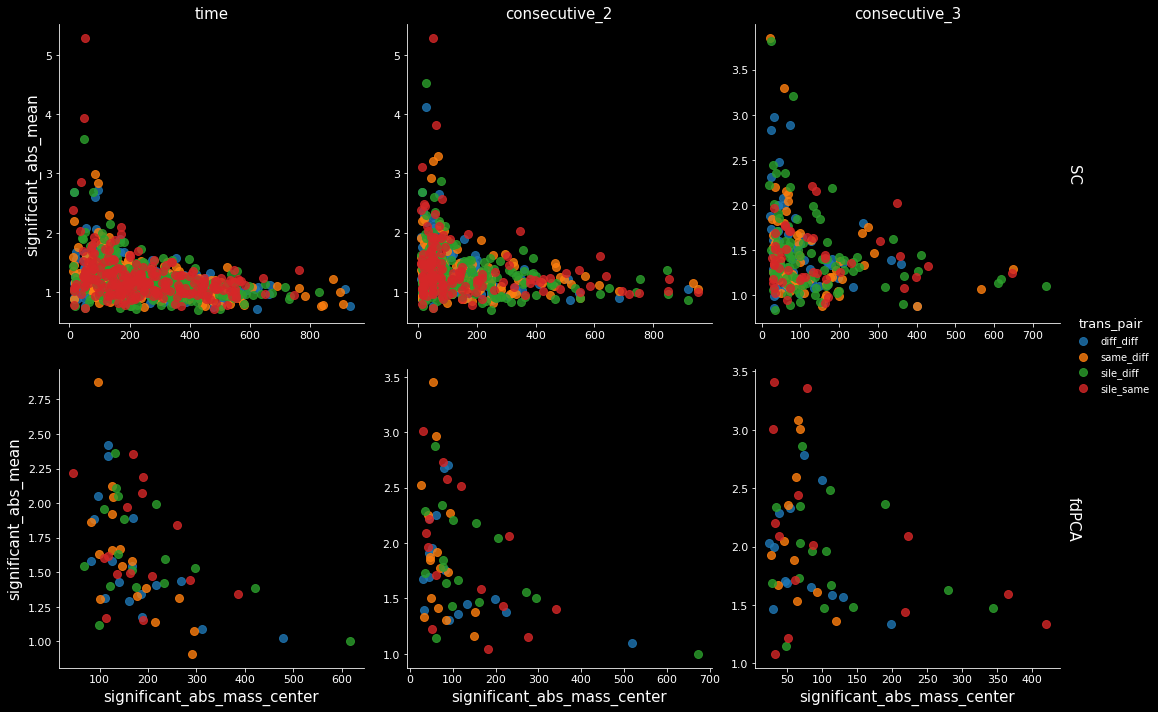

In [227]:
cols = ['time','consecutive_2', 'consecutive_3']
rows = ['SC', 'fdPCA']
amplitude = 'significant_abs_mean'
g = sns.lmplot(x='significant_abs_mass_center', y=amplitude, data=aggDF,
               hue='trans_pair', row='analysis', col='mult_comp_corr',
               fit_reg=False, sharex=False, sharey=False,
               row_order=rows, col_order=cols)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

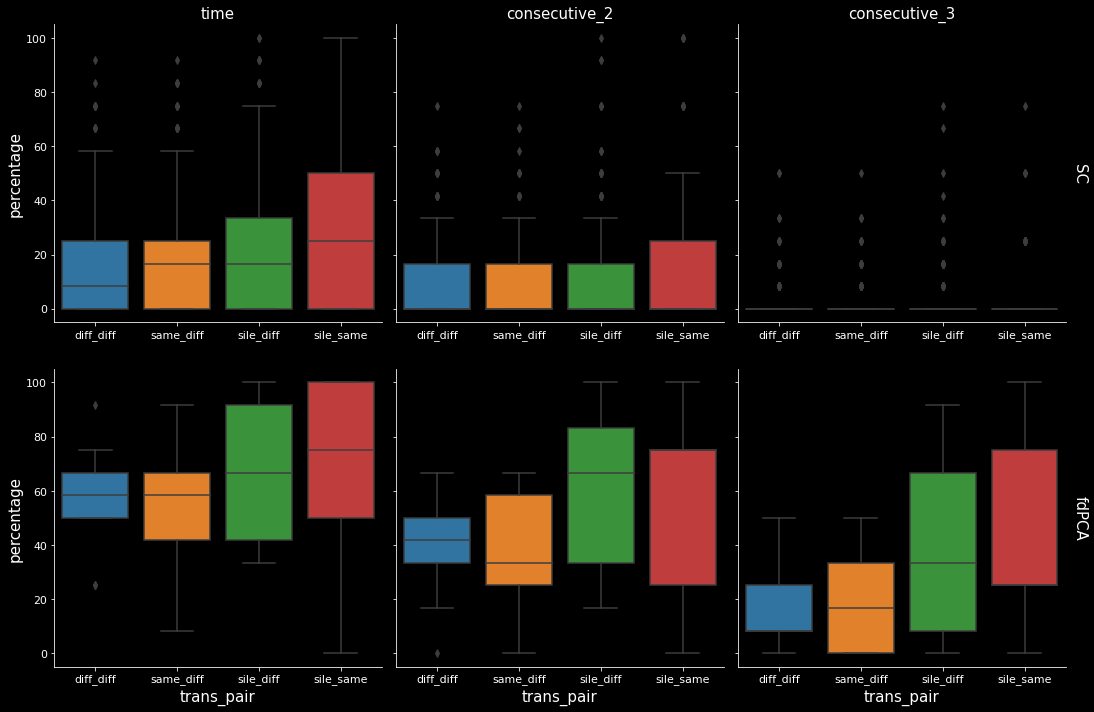

In [228]:
g = sns.catplot(kind='box',x='trans_pair', y='percentage', data=aggDF,
               row='analysis', col='mult_comp_corr', sharex=False, sharey=True,
               row_order=rows, col_order=cols)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")


now lets attempt to do the same plots considering  individual combinations of cell/probe/trans_pairs
aditionally, for the percentages of significant, pool across all cell/probes

also, further filters out unusede comparison corrections

In [229]:
print(classDF.columns)
correction = 'consecutive_3'
ff_comps = classDF.mult_comp_corr == correction
ff_analylis = classDF.analysis.isin(['SC', 'fdPCA'])

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
filtered = classDF.loc[ff_comps & ff_analylis, ord_cols]

good_cols = [col for col in ord_cols if col not in ['value']]
print('duplicates?: ', np.any(filtered.loc[:, good_cols].duplicated()))
print('nans?: ', any(filtered['value'].isna()))
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()
pivoted.head()

Index(['analysis', 'mult_comp_corr', 'region', 'context_pair', 'probe',
       'metric', 'value', 'id', 'trans_pair'],
      dtype='object')
duplicates?:  False
nans?:  False


metric,analysis,region,id,context_pair,trans_pair,probe,significant_abs_mass_center,significant_abs_mean,significant_abs_sum
0,SC,A1,AMT020a-02-1,0_1,sile_diff,2,0.0,0.0,0.0
1,SC,A1,AMT020a-02-1,0_1,sile_diff,3,0.0,0.0,0.0
2,SC,A1,AMT020a-02-1,0_1,sile_diff,4,0.0,0.0,0.0
3,SC,A1,AMT020a-02-1,0_1,sile_same,1,0.0,0.0,0.0
4,SC,A1,AMT020a-02-1,0_2,sile_diff,1,0.0,0.0,0.0


For each transition_pair category, calculates the mean metric, as well the the total number of values
(index x context_pair x probe), and the number of singificant values.

These numbers are categorized by region (A1 or PEG) and by analysis type (SC, dPCA).


In [230]:
# counts the total number of values for each comparison (SC, fDPCA) x (sile_diff, sile_same, diff_diff, same_diff)
# counts the proportion of signifciant vs non singificant(zero-zero) values
# decimates the more numerous comparisons??

# set the array to group by id, context_pair, and probe. Keeping analysis, region and transision_pair
# the final array should have analysis, region and trans pair as rowns, and total count, and significants as columns

def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

group_ready = pivoted.set_index(['analysis', 'region', 'trans_pair']).loc[:, filtered.metric.unique()]

agg_funcs = {'significant_abs_mass_center': [('lag_mean', nozero_mean)],
             amplitude: [('amplitude_mean', nozero_mean),
                                     ('total', 'size'),
                                     ('n_signif', nozero_count)]}

grouped = group_ready.groupby(['analysis', 'region', 'trans_pair']).agg(agg_funcs)
grouped.columns = grouped.columns.droplevel(0)
grouped['percent_signif'] = grouped.n_signif / grouped.total * 100

grouped

lag_mean  amplitude_mean  total  n_signif  \
analysis region trans_pair                                                
SC       A1     diff_diff    75.006244        1.579835   3048      71.0   
                same_diff    79.475199        1.574765   3048      58.0   
                sile_diff   127.775996        1.499608   3048      97.0   
                sile_same   110.425481        1.387426   1016      25.0   
         PEG    diff_diff   135.009291        1.455356   2148      64.0   
                same_diff   134.748956        1.488798   2148      60.0   
                sile_diff   143.454266        1.470135   2148      77.0   
                sile_same   173.983495        1.460050    716      29.0   
fdPCA    A1     diff_diff    61.124351        2.378617    108      16.0   
                same_diff    62.695339        2.413403    108      19.0   
                sile_diff   133.918455        2.010237    108      47.0   
                sile_same   121.576641        2.012319     36      16.0   
         PEG    diff_diff    93.546530        1.892055     96      18.0   
                same_diff    67.688093        2.057431     96      16.0   
                sile_diff   104.131293        1.950394     96      37.0   
                sile_same   135.152936        1.958103     32      13.0   

                            percent_signif  
analysis region trans_pair                  
SC       A1     diff_diff         2.329396  
                same_diff         1.902887  
                sile_diff         3.182415  
                sile_same         2.460630  
         PEG    diff_diff         2.979516  
                same_diff         2.793296  
                sile_diff         3.584730  
                sile_same         4.050279  
fdPCA    A1     diff_diff        14.814815  
                same_diff        17.592593  
                sile_diff        43.518519  
                sile_same        44.444444  
         PEG    diff_diff        18.750000  
                same_diff        16.666667  
                sile_diff        38.541667  
                sile_same        40.625000

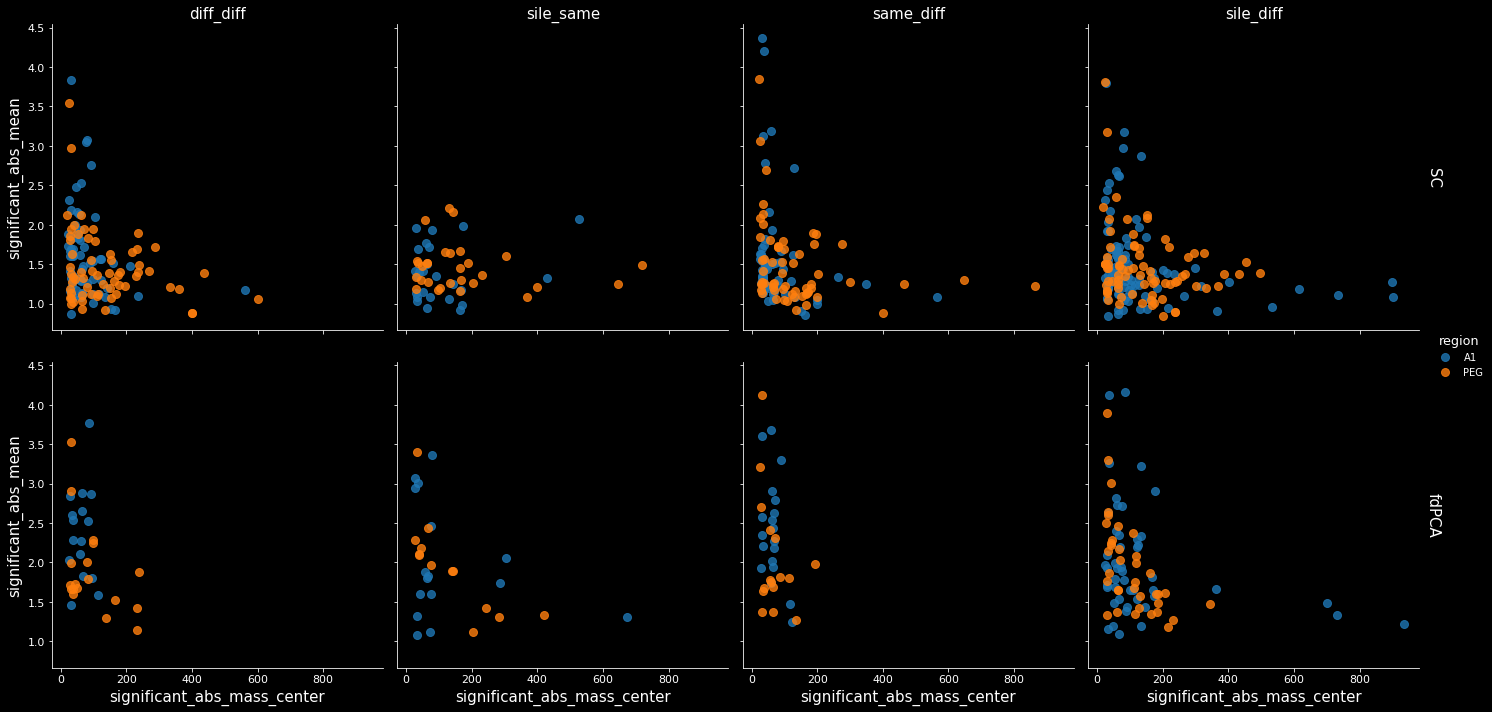

In [231]:
# removes zero-zero values, i.e. non singificnat values
toplot = pivoted.loc[pivoted[amplitude]>0, :]

rows = ['SC', 'fdPCA']
g = sns.lmplot(x='significant_abs_mass_center', y=amplitude, hue='region', data=toplot,
               row='analysis', col='trans_pair',
               fit_reg=False, sharex=True, sharey=True,
               row_order=rows)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")



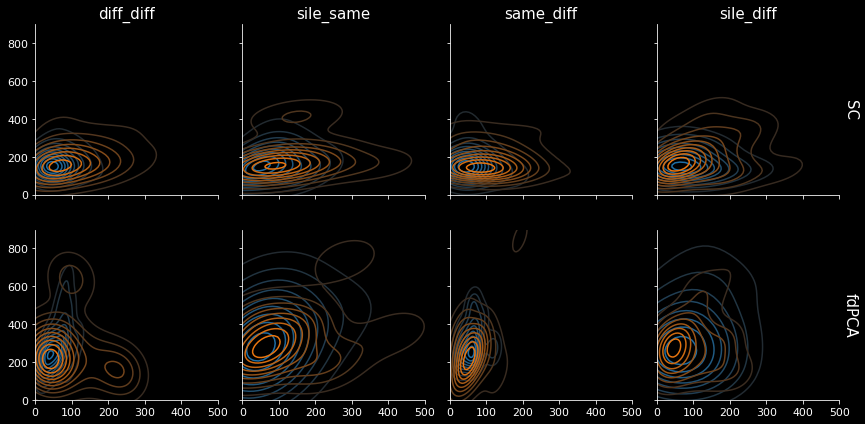

In [232]:
# attemps some bivaries KDE

def KDE(data, **kws):
    x = data['significant_abs_mass_center']
    y = data['significant_abs_sum']
    ax = plt.gca()
    sns.kdeplot(x, y, ax=ax, **kws)
    ax.set_xlim(0,500)
    ax.set_ylim(0,900)

g = sns.FacetGrid(data=toplot, row='analysis', col='trans_pair', hue='region')
g.map_dataframe(KDE)



g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

multiple comparisons correciton 


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


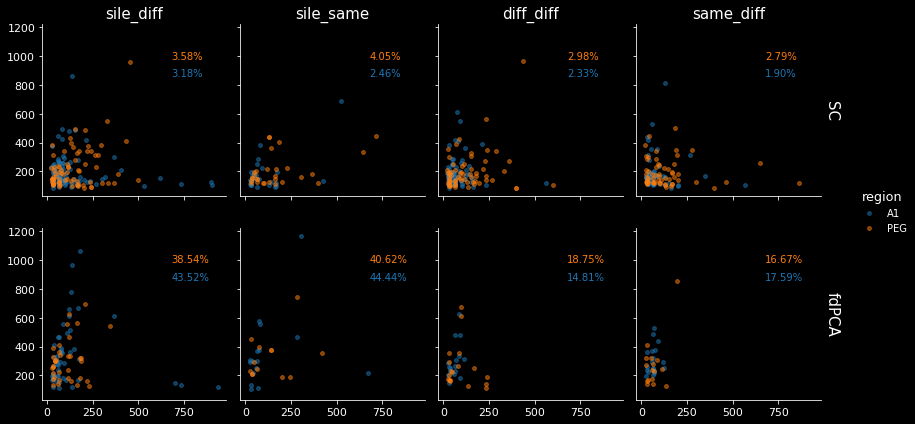

In [233]:
# grid with proportion anotations
print('multiple comparisons correciton ', )
def anotated_nozero_scatter(data, **kws):
    x = data['significant_abs_mass_center']
    y = data['significant_abs_sum']
    x = x[x>0]
    y = y[y>0]

    region = kws['label']
    total = data.shape[0]
    n_signif = len(x)
    percent_good = n_signif / total * 100

    ax = plt.gca()
    ax.scatter(x, y, s=15, alpha=0.5, **kws)

    offset = 0.7 if region == 'A1' else 0.8
    ax.text(.7, offset, f'{n_signif/total*100:.2f}%', transform=ax.transAxes,  **kws)

# note that this ploting fuction uses the unfiltered dataframe, since it calculates the proportion of
# significant values
g = sns.FacetGrid(data=pivoted, row='analysis', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True)
g.map_dataframe(anotated_nozero_scatter)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.tight_layout(rect=(0,0,0.98,0))


# explained variance plots

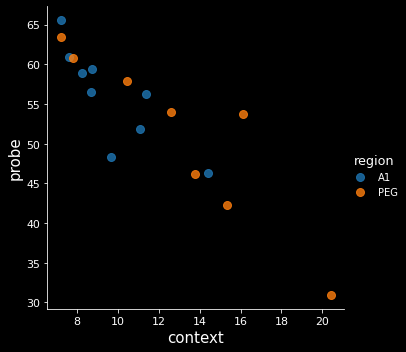

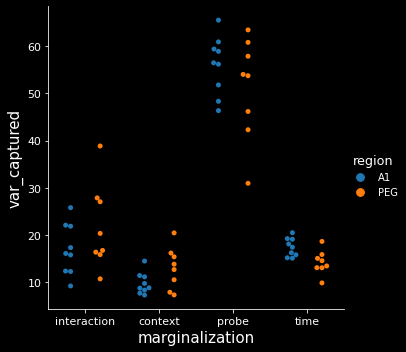

In [234]:
varDF = jl.load(Path('../data/210302_variance_explained_DF/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))
varDF['region'] = [region_map[site] for site in varDF.siteid]
varDF.rename(columns={'cpt': 'interaction', 'ct':'context', 'pt':'probe', 't':'time'}, inplace=True)
# print(varDF)
g = sns.lmplot(x='context', y='probe', hue='region', data=varDF, fit_reg=False)
# g = sns.lmplot(x='interaction', y='probe', hue='region', data=varDF, fit_reg=False)

molten = varDF.melt(id_vars=['siteid', 'region'], var_name='marginalization', value_name='var_captured')
g = sns.catplot(kind='swarm', x='marginalization', y='var_captured', hue='region', data=molten, dodge=True)

going over old parameter comparison between regions. Since I am no longer geting means of context_pairs and probe but
rather treating each id-trans_pair-probe as an obervation (and only those that are significant) the compoarisosn are no
longer paired. May the gods of statistics have mercy of my code.

In [264]:
amplitude = 'significant_abs_mean'
metrics = ['significant_abs_mass_center', amplitude]
id_vars = [col for col in toplot.columns if col not in metrics]
catDF = toplot.melt(id_vars=id_vars, value_vars=metrics,
                   var_name='metric', value_name='value')

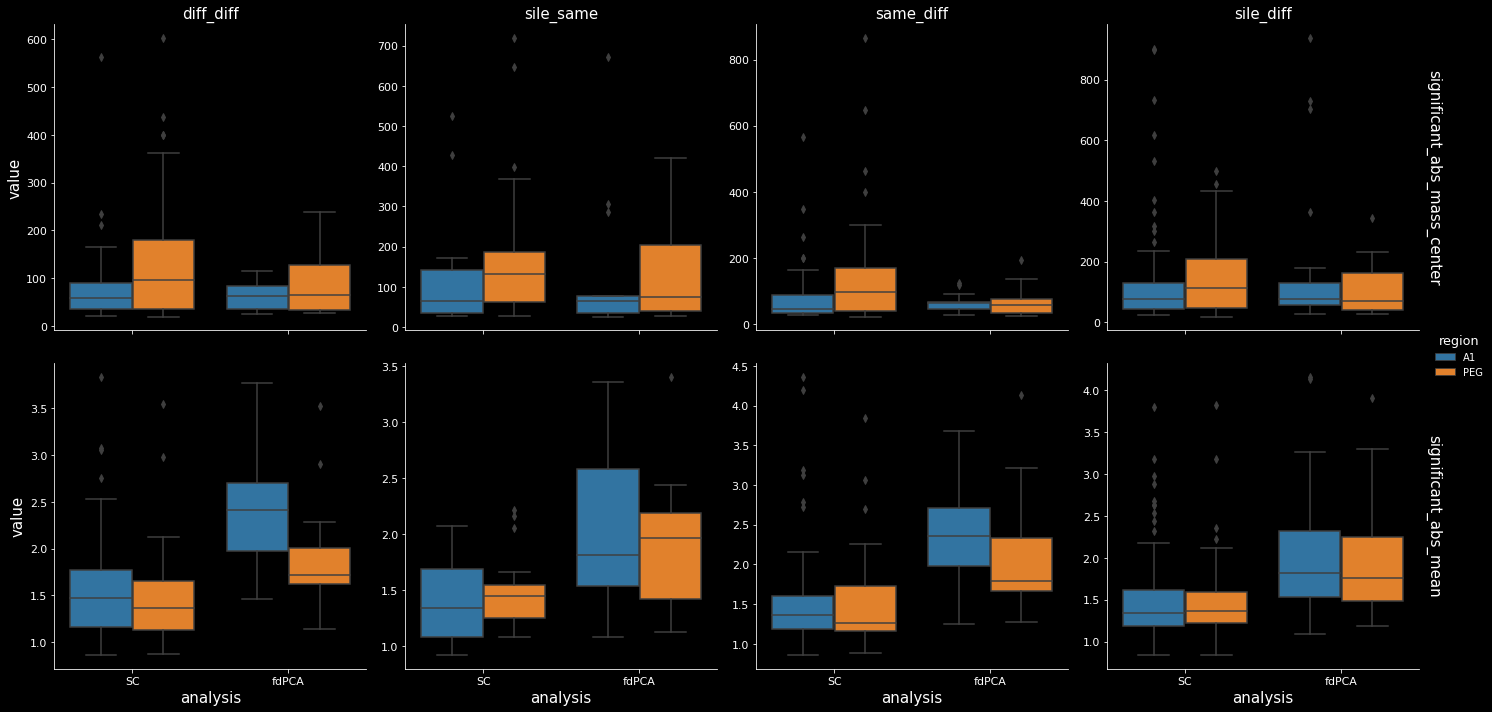

In [265]:
g = sns.catplot(kind='box',x='analysis', y='value', hue='region',
                row='metric', col='trans_pair',data=catDF, dodge=True,
                sharey=False)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

statannot(kind='box',x='analysis', y='value', hue='region',
                row='metric', col='trans_pair',data=catDF, dodge=True,
                sharey=False)







